In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys 
import pdb 
import pandas as pd

import scipy
from neurosim.models.ssr import StateSpaceRealization as SSR
from neurosim.models.ssr import gen_random_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
from glob import glob
from dca.cov_util import calc_pi_from_data, calc_pi_from_cross_cov_mats, calc_cov_from_cross_cov_mats, form_lag_matrix

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.append('../..')

In [4]:
from loaders import load_sabes
from utils import apply_df_filters
#from subspaces import CrossSubspaceIdentification, SubspaceIdentification, estimate_autocorrelation, BRSSID

### Scratch

In [15]:
indy_files = glob('/home/akumar/nse/neural_control/data/indy*')

In [16]:
dat = load_sabes(indy_files[0])

Processing spikes


100%|██████████| 1/1 [00:13<00:00, 13.62s/it]


In [18]:
y = np.squeeze(dat['spike_rates'])
pi = calc_pi_from_data(y, T=3)

In [28]:
ccmy = estimate_autocorrelation(y, 8)

In [46]:
calc_pi_from_cross_cov_mats(ccmy)

23.234529534801936

In [29]:
ssid = SubspaceIdentification()

In [30]:
# First verify that the PI is recovered from the canonical correlation coefficients

In [47]:
ht = ssid.form_hankel_toeplitz(ccmy, T=3)

In [49]:
cc = ht[1]

In [51]:
-0.5 * sum([np.log(1 - c**2) for c in cc])

23.234529534801784

In [27]:
# Next verify that the canonical correlation coefficients returned by psid yield the mutual informaton between neural data and behavior

In [53]:
def mutual_information(covjoint, covx, covy):
    return 0.5 * (np.linalg.slogdet(covx)[1] + np.linalg.slogdet(covy)[1] - np.linalg.slogdet(covjoint)[1])


In [54]:
z = np.squeeze(dat['behavior'])
ccmz = estimate_autocorrelation(z, 8)
ccm = estimate_autocorrelation(np.hstack([y, z]), 8)

In [67]:
mutual_information(calc_cov_from_cross_cov_mats(ccm[0:3]), calc_cov_from_cross_cov_mats(ccmy[0:3]), calc_cov_from_cross_cov_mats(ccmz[0:3]))

1.2246191502837576

In [57]:
bsid = PSIDSubspaceIdentification()

In [65]:
bht = bsid.form_hankel_toeplitz(ccm, 2, y.shape[1])

In [68]:
-0.5 * sum([np.log(1 - c**2) for c in bht[1]])

1.297904220247693

In [64]:
# Can also test on synthetic data

In [69]:
from ppmi.gaussian import gaussian_model

In [77]:
y, z, _, _, _, _, _ = gaussian_model()

In [94]:
ccmy = estimate_autocorrelation(y, 8)
ccmz = estimate_autocorrelation(z, 8)
ccm = estimate_autocorrelation(np.hstack([y, z]), 8)

In [95]:
mutual_information(calc_cov_from_cross_cov_mats(ccm[0:3]), calc_cov_from_cross_cov_mats(ccmy[0:3]), calc_cov_from_cross_cov_mats(ccmz[0:3]))

21.162377448897853

In [91]:
bht = bsid.form_hankel_toeplitz(np.transpose(ccm, (0, 2, 1)), 3, z.shape[1])

In [92]:
bht[1].shape

(40,)

In [93]:
-0.5 * sum([np.log(1 - c**2) for c in bht[1]])

12.369749093748798

### Testing on sabes lab data 

In [14]:
from loaders import load_sabes

In [16]:
dat = load_sabes('/home/akumar/nse/neural_control/data/indy_20160624_03.mat')
#dat = load_sabes('/mnt/Secondary/data/sabes/indy_20160624_03.mat')

Processing spikes


100%|██████████| 1/1 [00:08<00:00,  8.24s/it]


In [17]:
y = np.squeeze(dat['spike_rates'])
z = np.squeeze(dat['behavior'])

In [23]:
# How good is basic subspace identification
T = 5
ydim = y.shape[1]
zdim = z.shape[1]

yt = form_lag_matrix(y, 2*T)
zt = form_lag_matrix(z, 2*T)

# "Past" of y and "Future" of z
ypast = yt[:, :T*ydim]
zfut = zt[:, -T*zdim:]

In [25]:
linmodel = LinearRegression().fit(ypast, zfut)

In [27]:
linmodel.score(ypast, zfut)

0.4463327317412852

In [30]:
# Behaviorally relevant state
Z = scipy.linalg.lstsq(ypast, zfut)[0].T @ ypast.T

svd = TruncatedSVD(n_components=Z.shape[0] - 1)
svd.fit(Z.T)

U = svd.components_.T
Gamma_t = U @ np.diag(np.sqrt(svd.singular_values_))
Xt = np.linalg.pinv(Gamma_t) @ Z

In [34]:
Xt.shape

(9, 9989)

(10, 9989)

In [45]:
linmodel = LinearRegression().fit(Xt.T, z[]])
linmodel.score(Xt.T, z[:-9])

0.2724127559060829

In [48]:
from subspaces import brssid

In [49]:
brssid(y, z, 6, 5)

(0.3856758697459933,
 array([[ 1.10888572e-02,  1.87695522e-02, -4.52275281e-02,
         -4.49973443e-03, -6.69901021e-02, -1.05202299e-01],
        [-1.11765504e-02, -1.06505708e-02, -3.46171902e-04,
          1.78712328e-02, -2.46493286e-02, -8.88320316e-02],
        [ 6.99177799e-03, -6.71297370e-02,  4.55281591e-01,
         -3.29268667e-02, -1.13228261e-01,  4.71852872e-01],
        [-1.02273248e-02,  7.89429273e-03,  3.33586207e-02,
          4.61172847e-03, -6.12541809e-02,  1.04995682e-01],
        [-1.81443997e-03,  2.20271576e-02, -5.39270127e-02,
         -1.19622246e-01, -8.45296312e-02, -2.34750074e-01],
        [-9.03421747e-03, -5.75864409e-02,  1.79035044e-01,
         -1.53862898e-02, -4.69384625e-01,  1.04014644e+00],
        [-6.71747751e-03,  3.72016325e-02, -6.40972739e-03,
         -2.95132102e-02,  5.95741302e-02, -6.81051348e-02],
        [ 1.02635306e-01, -1.44866209e-01,  1.91831482e-01,
          5.20779439e-02,  1.54055935e-03, -2.51729609e-02],
        [-2

In [26]:
# Test the KF decoding frm the bsid

In [ ]:
# Test on synthetic data

In [6]:
A, B, C = gen_random_model(size=6)

In [7]:
C = scipy.stats.ortho_group.rvs(dim=20)[:, 0:6]


In [8]:
ssr = SSR(A, B, C)

In [9]:
X, x = ssr.trajectory(T=int(1e5), return_state=True)

In [10]:
y = x[:, 0:18]
z = x[:, 18:]

In [11]:
bsid2 = BRSSID()

In [12]:
Ass,  _, _, r2 = bsid2.identify(y, z, order=6, T=5)

In [13]:
r2

0.09618722855310002

In [100]:
np.linalg.eigvals(Ass)

array([-0.62863086+0.j        , -0.50425209+0.3089909j ,
       -0.50425209-0.3089909j ,  0.15608834+0.51544694j,
        0.15608834-0.51544694j,  0.26256323+0.j        ])

In [99]:
np.linalg.eigvals(A)

array([-0.51242636+0.27857446j, -0.51242636-0.27857446j,
        0.13910177+0.51559358j,  0.13910177-0.51559358j,
        0.17536933+0.01531477j,  0.17536933-0.01531477j])

In [98]:
np.linalg.norm(A - Ass)

2.4086981303915054

In [54]:
np.arange(100)[5:-5 + 1]

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95])

In [53]:
xt.shape
z.shape

(100001, 2)

In [49]:
from sklearn.linear_model import LinearRegression

### Using the actual PSID package

In [5]:
import PSID
from PSID.evaluation import evalPrediction
from decoders import expand_state_space
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
# Run over all data files, dims 1 to 31, i = 5, cross-validated

In [6]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')

In [67]:
rl = []
dimvals = np.arange(1, 31)
for i, data_file in tqdm(enumerate(data_files)):

    dat = load_sabes(data_file)
    y = dat['spike_rates'].squeeze()
    z = dat['behavior']
    z, y = expand_state_space([z], [y])
    z = z[0]
    y = y[0]

    for j, d in enumerate(dimvals):
        for fidx, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(y)):

            ytrain = y[train_idxs]
            ytest = y[test_idxs]

            ztrain = z[train_idxs]
            ztest = z[test_idxs]

            idsys = PSID.PSID(ytrain, ztrain, nx=d, n1=d, i=5)
            zpred, _, _ = idsys.predict(ytest)
            r2 = evalPrediction(ztest, zpred, 'R2')

            result = {}
            result['data_file'] = data_file
            result['dim'] = d
            result['fidx'] = fidx
            result['r2'] = r2

            rl.append(result)

38it [1:01:40, 97.38s/it] 


In [7]:
import pickle

In [8]:
# with open('psid_tmp.pkl', 'wb') as f:
#     f.write(pickle.dumps(rl))
with open('psid_tmp.pkl', 'rb') as f:
    rl = pickle.load(f)

In [9]:
# Aditionally, fit the model at fixed dimensionality (d = 6) on FCCA/PCA projections
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)


with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
    'loco_20170213_02.mat',
    'loco_20170215_02.mat',
    'loco_20170227_04.mat',
    'loco_20170228_02.mat',
    'loco_20170301_05.mat',
    'loco_20170302_02.mat']

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
loco_df = apply_df_filters(loco_df, data_file = good_loco_files)

In [11]:
sabes_df = pd.concat([indy_df, loco_df])

In [60]:
data_files = np.unique(sabes_df['data_file'].values)
dimvals = np.arange(6, 31)
for i, data_file in tqdm(enumerate(data_files)):

    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    y = dat['spike_rates'].squeeze()
    z = dat['behavior']
    z, y = expand_state_space([z], [y])
    z = z[0]
    y = y[0]

    for j, d in enumerate(dimvals):
        for fidx, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(y)):

            ytrain = y[train_idxs]
            ytest = y[test_idxs]

            ztrain = z[train_idxs]
            ztest = z[test_idxs]

            df = apply_df_filters(sabes_df, data_file=data_file, dim=d, fold_idx=fidx, dimreduc_method='PCA')
            assert(df.shape[0] == 1)
            ytrain_pca = ytrain @ df.iloc[0]['coef'][:, 0:d]            
            ytest_pca = ytest @ df.iloc[0]['coef'][:, 0:d]

            idsys = PSID.PSID(ytrain_pca, ztrain, nx=6, n1=6, i=5)
            zpred, _, _ = idsys.predict(ytest_pca)
            r2_pca = evalPrediction(ztest, zpred, 'R2')

            df = apply_df_filters(sabes_df, data_file=data_file, dim=d, fold_idx=fidx, dimreduc_method='LQGCA')
            assert(df.shape[0] == 1)
            ytrain_fca = ytrain @ df.iloc[0]['coef'][:, 0:d]            
            ytest_fca = ytest @ df.iloc[0]['coef'][:, 0:d]

            idsys = PSID.PSID(ytrain_fca, ztrain, nx=6, n1=6, i=5)
            zpred, _, _ = idsys.predict(ytest_fca)
            r2_fca = evalPrediction(ztest, zpred, 'R2')

            result = {}
            result['data_file'] = data_file
            result['dim'] = d
            result['fidx'] = fidx
            result['r2_pca'] = r2_pca
            result['r2_fca'] = r2_fca

            rl.append(result)

38it [39:48, 62.84s/it] 


In [61]:
with open('dimreduc_psid.pkl', 'wb') as f:
    f.write(pickle.dumps(rl))

In [26]:
# Open and plot

In [12]:
with open('psid_tmp.pkl', 'rb') as f:
    rl1 = pickle.load(f)

In [85]:
with open('dimreduc_psid.pkl', 'rb') as f:
    rl2 = pickle.load(f)

In [13]:
df1 = pd.DataFrame(rl1)

In [86]:
df2 = pd.DataFrame(rl2)

In [12]:
with open('/mnt/Secondary/data/postprocessed/sabes_kca_decodign_df.dat', 'rb') as f:
    pca_decoding_df = pickle.load(f)

In [13]:
indy_data_files = np.unique(indy_df['data_file'].values)
loco_data_files = np.unique(loco_df['data_file'].values)

In [16]:
dims = np.arange(1, 31)
r2fc = np.zeros((len(indy_data_files) + len(loco_data_files), dims.size, 5))
sr2_vel_pca = np.zeros((len(indy_data_files) + len(loco_data_files), dims.size, 5))

# Collect decoding results for PCA/FCCA for comparison
for i, data_file in tqdm(enumerate(indy_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(indy_df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='LQGCA')
            assert(dim_fold_df.shape[0] == 1)
            r2fc[i, j, f] = dim_fold_df.iloc[0]['r2'][1]

            pca_df = apply_df_filters(pca_decoding_df, data_file=data_file, dim=dim, fold_idx=f, dr_method='PCA')
            assert(pca_df.shape[0] == 1)
            sr2_vel_pca[i, j, f] = pca_df.iloc[0]['r2'][1]

for i, data_file in tqdm(enumerate(loco_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(loco_df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='LQGCA')
            assert(dim_fold_df.shape[0] == 1)
            r2fc[i + len(indy_data_files), j, f] = dim_fold_df.iloc[0]['r2'][1]

            pca_df = apply_df_filters(loco_df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='PCA')
            assert(pca_df.shape[0] == 1)
            sr2_vel_pca[i + len(indy_data_files), j, f] = pca_df.iloc[0]['r2'][1]

28it [00:13,  2.05it/s]
7it [00:01,  4.52it/s]


In [48]:
df1['data_file'].values

array(['/mnt/Secondary/data/sabes/indy_20161017_02.mat',
       '/mnt/Secondary/data/sabes/indy_20161017_02.mat',
       '/mnt/Secondary/data/sabes/indy_20161017_02.mat', ...,
       '/mnt/Secondary/data/sabes/loco_20170302_02.mat',
       '/mnt/Secondary/data/sabes/loco_20170302_02.mat',
       '/mnt/Secondary/data/sabes/loco_20170302_02.mat'], dtype=object)

In [22]:
# PSID r2
dims = np.arange(1, 31)
psid_r2_f = np.zeros((len(indy_data_files) + len(loco_data_files), dims.size, 5))
for i, data_file in tqdm(enumerate(indy_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(df1, data_file='mnt/Secondary/data/sabes/%s' % data_file, dim=dim, fidx=f)
            assert(dim_fold_df.shape[0] == 1)
            psid_r2_f[i, j, f] = np.mean(dim_fold_df.iloc[0]['r2'][2:4])

for i, data_file in tqdm(enumerate(loco_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(df1, data_file='mnt/Secondary/data/sabes/%s' % data_file, dim=dim, fidx=f)
            assert(dim_fold_df.shape[0] == 1)
            psid_r2_f[i + len(indy_data_files), j, f] = np.mean(dim_fold_df.iloc[0]['r2'][2:4])


28it [00:04,  6.81it/s]
7it [00:01,  6.92it/s]


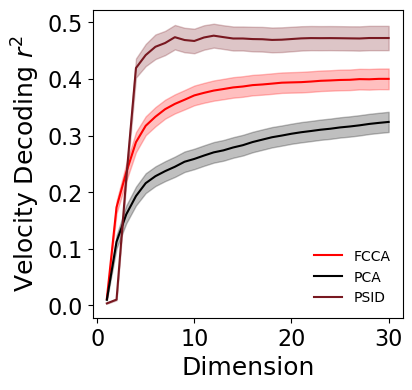

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = ['black', 'red', '#781820', '#5563fa']
dim_vals = np.arange(1, 31)

# # DCA averaged over folds
# dca_r2 = np.mean(r2[:, :, 1, :, 1], axis=2)
# # KCA averaged over folds
# kca_r2 = np.mean(r2[:, :, 2, :, 1], axis=2)

# FCCA averaged over folds
fca_r2 = np.mean(r2fc[:, :, :], axis=2)
# PCA
pca_r2 = np.mean(sr2_vel_pca, axis=2)
psid_r2 = np.mean(psid_r2_f, axis=2)
# ax.fill_between(dim_vals, np.mean(dca_r2, axis=0) + np.std(dca_r2, axis=0)/np.sqrt(35),
#                 np.mean(dca_r2, axis=0) - np.std(dca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
# ax.plot(dim_vals, np.mean(dca_r2, axis=0), color=colors[0])
# ax.fill_between(dim_vals, np.mean(kca_r2, axis=0) + np.std(kca_r2, axis=0)/np.sqrt(35),
#                 np.mean(kca_r2, axis=0) - np.std(kca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
# ax.plot(dim_vals, np.mean(kca_r2, axis=0), color=colors[1])
ax.fill_between(dim_vals, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(35),
                np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2, axis=0), color=colors[1])

ax.fill_between(dim_vals, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(35),
                np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
ax.plot(dim_vals, np.mean(pca_r2, axis=0), color=colors[0])

ax.fill_between(dim_vals, np.mean(psid_r2, axis=0) + np.std(psid_r2, axis=0)/np.sqrt(35),
                np.mean(psid_r2, axis=0) - np.std(psid_r2, axis=0)/np.sqrt(35), color=colors[2], alpha=0.25)
ax.plot(dim_vals, np.mean(psid_r2, axis=0), color=colors[2])

# Plot the paired differences
# ax.plot(dim_vals, np.mean(fca_r2 - pca_r2, axis=0))
# ax.fill_between(dim_vals, np.mean(fca_r2 - pca_r2, axis=0) + np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35),
#                 np.mean(fca_r2 - pca_r2, axis=0) - np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)

ax.set_xlabel('Dimension', fontsize=18)
ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(['FCCA', 'PCA', 'PSID'], fontsize=10, frameon=False, loc='lower right')
# fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/psid.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# What is the fraction that FCCA attains
np.mean(fca_r2, axis=0)[9]/np.mean(psid_r2, axis=0)[9]

0.7941082900519905

In [96]:
dims = np.arange(6, 31)
psid_r2_dr = np.zeros((len(indy_data_files) + len(loco_data_files), dims.size, 5, 2))
for i, data_file in tqdm(enumerate(indy_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(df2, data_file=data_file, dim=dim, fidx=f)
            #assert(dim_fold_df.shape[0] == 1)
            psid_r2_dr[i, j, f, 0] = np.mean(dim_fold_df.iloc[0]['r2_pca'][2:4])
            psid_r2_dr[i, j, f, 1] = np.mean(dim_fold_df.iloc[0]['r2_fca'][2:4])

for i, data_file in tqdm(enumerate(loco_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(df2, data_file=data_file, dim=dim, fidx=f)
            #assert(dim_fold_df.shape[0] == 1)
            psid_r2_dr[i + len(indy_data_files), j, f, 0] = np.mean(dim_fold_df.iloc[0]['r2_pca'][2:4])
            psid_r2_dr[i + len(indy_data_files), j, f, 1] = np.mean(dim_fold_df.iloc[0]['r2_fca'][2:4])


28it [00:10,  2.61it/s]
7it [00:02,  3.45it/s]


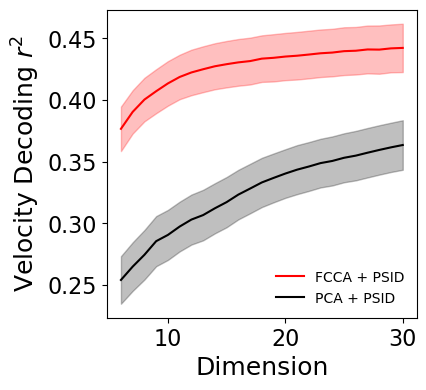

In [99]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = ['black', 'red', '#781820', '#5563fa']
dim_vals = np.arange(6, 31)

# # DCA averaged over folds
# dca_r2 = np.mean(r2[:, :, 1, :, 1], axis=2)
# # KCA averaged over folds
# kca_r2 = np.mean(r2[:, :, 2, :, 1], axis=2)

# FCCA averaged over folds
fca_r2 = np.mean(psid_r2_dr[:, :, :, 1], axis=2)
# PCA
pca_r2 = np.mean(psid_r2_dr[:, :, :, 0], axis=2)


ax.fill_between(dim_vals, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(35),
                np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2, axis=0), color=colors[1])

ax.fill_between(dim_vals, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(35),
                np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
ax.plot(dim_vals, np.mean(pca_r2, axis=0), color=colors[0])

# Plot the paired differences
# ax.plot(dim_vals, np.mean(fca_r2 - pca_r2, axis=0))
# ax.fill_between(dim_vals, np.mean(fca_r2 - pca_r2, axis=0) + np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35),
#                 np.mean(fca_r2 - pca_r2, axis=0) - np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)

ax.set_xlabel('Dimension', fontsize=18)
ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(['FCCA + PSID', 'PCA + PSID'], fontsize=10, frameon=False, loc='lower right')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/psid2.pdf', bbox_inches='tight', pad_inches=0)
#fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/psid.pdf', bbox_inches='tight', pad_inches=0)

### What happens when we use the projection discovered by PSID but otherwise use normal linear regression (no denoising)

In [7]:
import pdb

In [16]:
from decoders import lr_decoder

In [39]:
rl = []
dimvals = np.arange(1, 31)
for i, data_file in tqdm(enumerate(data_files)):

    dat = load_sabes(data_file)
    y = dat['spike_rates'].squeeze()
    z = dat['behavior']
    z, y = expand_state_space([z], [y])
    z = z[0]
    y = y[0]

    for j, d in enumerate(dimvals):
        for fidx, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(y)):

            ytrain = y[train_idxs]
            ytest = y[test_idxs]

            ztrain = z[train_idxs]
            ztest = z[test_idxs]

            idsys = PSID.PSID(ytrain, ztrain, nx=d, n1=d, i=5)

            ytrain_proj = ytrain @ idsys.C
            ytest_proj = ytest @ idsys.C


            ztrain = dat['behavior'][train_idxs]
            ztest = dat['behavior'][test_idxs]

            _, lr_r2_vel, _, _1 = lr_decoder(ytest_proj, ytrain_proj, ztest, ztrain, 4, 4, 5)

            result = {}
            result['data_file'] = data_file
            result['dim'] = d
            result['fidx'] = fidx
            result['r2'] = lr_r2_vel

            rl.append(result)
psid_df = pd.DataFrame(rl)

38it [56:20, 88.96s/it] 


In [14]:
# with open('psid_tmp_proj.pkl', 'wb') as f:
#     f.write(pickle.dumps(psid_df))
with open('psid_tmp_proj.pkl', 'rb') as f:
    psid_df = pickle.load(f)

In [15]:
# PSID r2
dims = np.arange(1, 31)
psid_r2_f = np.zeros((len(indy_data_files) + len(loco_data_files), dims.size, 5))
for i, data_file in tqdm(enumerate(indy_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(psid_df, data_file='mnt/Secondary/data/sabes/%s' % data_file, dim=dim, fidx=f)
            assert(dim_fold_df.shape[0] == 1)
            psid_r2_f[i, j, f] = np.mean(dim_fold_df.iloc[0]['r2'])

for i, data_file in tqdm(enumerate(loco_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(psid_df, data_file='mnt/Secondary/data/sabes/%s' % data_file, dim=dim, fidx=f)
            assert(dim_fold_df.shape[0] == 1)
            psid_r2_f[i + len(indy_data_files), j, f] = np.mean(dim_fold_df.iloc[0]['r2'])


28it [00:04,  6.69it/s]
7it [00:01,  6.65it/s]


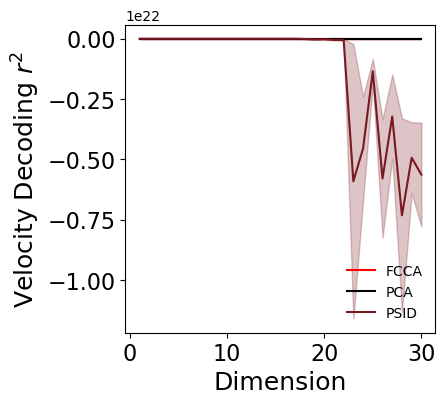

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = ['black', 'red', '#781820', '#5563fa']
dim_vals = np.arange(1, 31)

# # DCA averaged over folds
# dca_r2 = np.mean(r2[:, :, 1, :, 1], axis=2)
# # KCA averaged over folds
# kca_r2 = np.mean(r2[:, :, 2, :, 1], axis=2)

# FCCA averaged over folds
fca_r2 = np.mean(r2fc[:, :, :], axis=2)
# PCA
pca_r2 = np.mean(sr2_vel_pca, axis=2)
psid_r2 = np.mean(psid_r2_f, axis=2)
# ax.fill_between(dim_vals, np.mean(dca_r2, axis=0) + np.std(dca_r2, axis=0)/np.sqrt(35),
#                 np.mean(dca_r2, axis=0) - np.std(dca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
# ax.plot(dim_vals, np.mean(dca_r2, axis=0), color=colors[0])
# ax.fill_between(dim_vals, np.mean(kca_r2, axis=0) + np.std(kca_r2, axis=0)/np.sqrt(35),
#                 np.mean(kca_r2, axis=0) - np.std(kca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
# ax.plot(dim_vals, np.mean(kca_r2, axis=0), color=colors[1])
ax.fill_between(dim_vals, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(35),
                np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2, axis=0), color=colors[1])

ax.fill_between(dim_vals, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(35),
                np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
ax.plot(dim_vals, np.mean(pca_r2, axis=0), color=colors[0])

ax.fill_between(dim_vals, np.mean(psid_r2, axis=0) + np.std(psid_r2, axis=0)/np.sqrt(35),
                np.mean(psid_r2, axis=0) - np.std(psid_r2, axis=0)/np.sqrt(35), color=colors[2], alpha=0.25)
ax.plot(dim_vals, np.mean(psid_r2, axis=0), color=colors[2])

# Plot the paired differences
# ax.plot(dim_vals, np.mean(fca_r2 - pca_r2, axis=0))
# ax.fill_between(dim_vals, np.mean(fca_r2 - pca_r2, axis=0) + np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35),
#                 np.mean(fca_r2 - pca_r2, axis=0) - np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)

ax.set_xlabel('Dimension', fontsize=18)
ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(['FCCA', 'PCA', 'PSID'], fontsize=10, frameon=False, loc='lower right')
# fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/psid.pdf', bbox_inches='tight', pad_inches=0)

In [24]:
# Doesn't work out well

### Getting PSID results in S1

In [25]:
with open('/mnt/Secondary/data/postprocessed/loco_lag1_decodingdf.dat', 'rb') as f:
    result_list = pickle.load(f)
with open('/mnt/Secondary/data/postprocessed/indy_S1_decodingdf.dat', 'rb') as f:
    rl2 = pickle.load(f)

loco_df = pd.DataFrame(result_list)
# filter by good files
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files, 
                            loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 
                            'boxcox': 0.5, 'spike_threshold': 100, 'region': 'S1'})

indy_df = pd.DataFrame(rl2)        

sabes_df = pd.concat([loco_df, indy_df])

In [38]:
data_files = np.unique(sabes_df['data_file'].values )

In [39]:
dims = np.arange(1, 31)
r2fc = np.zeros((len(data_files), dims.size, 5))
sr2_vel_pca = np.zeros((len(data_files), dims.size, 5))

# Collect decoding results for PCA/FCCA for comparison
for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(sabes_df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='LQGCA')
            assert(dim_fold_df.shape[0] == 1)
            r2fc[i, j, f] = dim_fold_df.iloc[0]['r2'][1]

            pca_df = apply_df_filters(sabes_df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='PCA')
            assert(pca_df.shape[0] == 1)
            sr2_vel_pca[i, j, f] = pca_df.iloc[0]['r2'][1]

8it [00:01,  4.30it/s]


In [41]:
rl = []
dimvals = np.arange(1, 31)
for i, data_file in tqdm(enumerate(data_files)):

    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file, region='S1')
    y = dat['spike_rates'].squeeze()
    z = dat['behavior']
    z, y = expand_state_space([z], [y])
    z = z[0]
    y = y[0]

    for j, d in enumerate(dimvals):
        for fidx, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(y)):

            ytrain = y[train_idxs]
            ytest = y[test_idxs]

            ztrain = z[train_idxs]
            ztest = z[test_idxs]

            idsys = PSID.PSID(ytrain, ztrain, nx=d, n1=d, i=5)
            zpred, _, _ = idsys.predict(ytest)
            r2 = evalPrediction(ztest, zpred, 'R2')

            result = {}
            result['data_file'] = data_file
            result['dim'] = d
            result['fidx'] = fidx
            result['r2'] = r2

            rl.append(result)

0it [00:00, ?it/s]

96


1it [01:33, 93.59s/it]

96


2it [04:03, 126.64s/it]

96


3it [07:22, 159.91s/it]

96


4it [09:05, 137.34s/it]

96


5it [12:18, 157.54s/it]

96


6it [15:08, 161.57s/it]

96


7it [16:46, 140.99s/it]

96


8it [20:02, 150.30s/it]


In [42]:
df1 = pd.DataFrame(rl)

In [46]:
data_files = np.unique(sabes_df['data_file'].values)
dimvals = np.arange(6, 31)
rl2 = []
for i, data_file in tqdm(enumerate(data_files)):

    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file, region='S1')
    y = dat['spike_rates'].squeeze()
    z = dat['behavior']
    z, y = expand_state_space([z], [y])
    z = z[0]
    y = y[0]

    for j, d in enumerate(dimvals):
        for fidx, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(y)):

            ytrain = y[train_idxs]
            ytest = y[test_idxs]

            ztrain = z[train_idxs]
            ztest = z[test_idxs]

            df = apply_df_filters(sabes_df, data_file=data_file, dim=d, fold_idx=fidx, dimreduc_method='PCA')
            assert(df.shape[0] == 1)
            ytrain_pca = ytrain @ df.iloc[0]['coef'][:, 0:d]            
            ytest_pca = ytest @ df.iloc[0]['coef'][:, 0:d]

            idsys = PSID.PSID(ytrain_pca, ztrain, nx=6, n1=6, i=5)
            zpred, _, _ = idsys.predict(ytest_pca)
            r2_pca = evalPrediction(ztest, zpred, 'R2')

            df = apply_df_filters(sabes_df, data_file=data_file, dim=d, fold_idx=fidx, dimreduc_method='LQGCA')
            assert(df.shape[0] == 1)
            ytrain_fca = ytrain @ df.iloc[0]['coef'][:, 0:d]            
            ytest_fca = ytest @ df.iloc[0]['coef'][:, 0:d]

            idsys = PSID.PSID(ytrain_fca, ztrain, nx=6, n1=6, i=5)
            zpred, _, _ = idsys.predict(ytest_fca)
            r2_fca = evalPrediction(ztest, zpred, 'R2')

            result = {}
            result['data_file'] = data_file
            result['dim'] = d
            result['fidx'] = fidx
            result['r2_pca'] = r2_pca
            result['r2_fca'] = r2_fca

            rl2.append(result)

0it [00:00, ?it/s]

96


1it [01:39, 99.09s/it]

96


2it [03:12, 95.95s/it]

96


3it [05:20, 110.32s/it]

96


4it [06:21, 90.78s/it] 

96


5it [08:08, 96.78s/it]

96


6it [09:43, 96.28s/it]

96


7it [10:46, 85.30s/it]

96


8it [12:46, 95.87s/it]


In [48]:
df2 = pd.DataFrame(rl2)

In [49]:
with open('psid_tmp_S1.pkl', 'wb') as f:
    f.write(pickle.dumps(df1))
    f.write(pickle.dumps(df2))

In [53]:
df1.shape

(1200, 4)

In [55]:
# PSID r2
dims = np.arange(1, 31)
psid_r2_f = np.zeros((len(data_files), dims.size, 5))
for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(df1, data_file=data_file, dim=dim, fidx=f)
            assert(dim_fold_df.shape[0] == 1)
            psid_r2_f[i, j, f] = np.mean(dim_fold_df.iloc[0]['r2'][2:4])

8it [00:00, 12.52it/s]


In [56]:
dims = np.arange(6, 31)
psid_r2_dr = np.zeros((len(data_files), dims.size, 5, 2))
for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(df2, data_file=data_file, dim=dim, fidx=f)
            assert(dim_fold_df.shape[0] == 1)
            psid_r2_dr[i, j, f, 0] = np.mean(dim_fold_df.iloc[0]['r2_pca'][2:4])
            psid_r2_dr[i, j, f, 1] = np.mean(dim_fold_df.iloc[0]['r2_fca'][2:4])

8it [00:00, 13.60it/s]


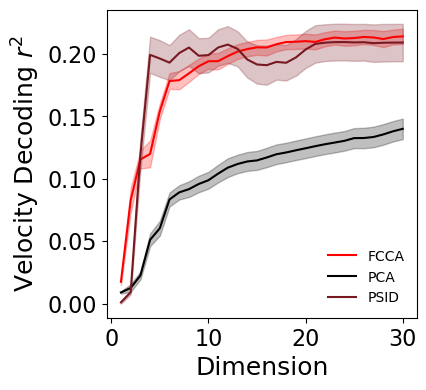

In [58]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = ['black', 'red', '#781820', '#5563fa']
dim_vals = np.arange(1, 31)

# # DCA averaged over folds
# dca_r2 = np.mean(r2[:, :, 1, :, 1], axis=2)
# # KCA averaged over folds
# kca_r2 = np.mean(r2[:, :, 2, :, 1], axis=2)

# FCCA averaged over folds
fca_r2 = np.mean(r2fc[:, :, :], axis=2)
# PCA
pca_r2 = np.mean(sr2_vel_pca, axis=2)
psid_r2 = np.mean(psid_r2_f, axis=2)
# ax.fill_between(dim_vals, np.mean(dca_r2, axis=0) + np.std(dca_r2, axis=0)/np.sqrt(35),
#                 np.mean(dca_r2, axis=0) - np.std(dca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
# ax.plot(dim_vals, np.mean(dca_r2, axis=0), color=colors[0])
# ax.fill_between(dim_vals, np.mean(kca_r2, axis=0) + np.std(kca_r2, axis=0)/np.sqrt(35),
#                 np.mean(kca_r2, axis=0) - np.std(kca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
# ax.plot(dim_vals, np.mean(kca_r2, axis=0), color=colors[1])
ax.fill_between(dim_vals, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(35),
                np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2, axis=0), color=colors[1])

ax.fill_between(dim_vals, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(35),
                np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
ax.plot(dim_vals, np.mean(pca_r2, axis=0), color=colors[0])

ax.fill_between(dim_vals, np.mean(psid_r2, axis=0) + np.std(psid_r2, axis=0)/np.sqrt(35),
                np.mean(psid_r2, axis=0) - np.std(psid_r2, axis=0)/np.sqrt(35), color=colors[2], alpha=0.25)
ax.plot(dim_vals, np.mean(psid_r2, axis=0), color=colors[2])

# Plot the paired differences
# ax.plot(dim_vals, np.mean(fca_r2 - pca_r2, axis=0))
# ax.fill_between(dim_vals, np.mean(fca_r2 - pca_r2, axis=0) + np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35),
#                 np.mean(fca_r2 - pca_r2, axis=0) - np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)

ax.set_xlabel('Dimension', fontsize=18)
ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(['FCCA', 'PCA', 'PSID'], fontsize=10, frameon=False, loc='lower right')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/psid_S1.pdf', bbox_inches='tight', pad_inches=0)

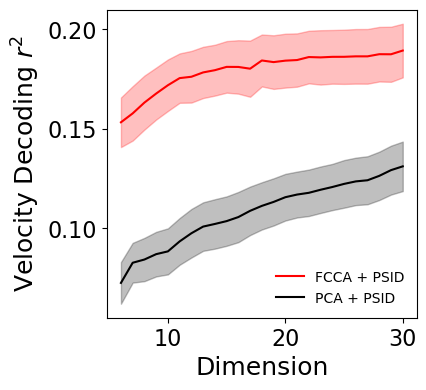

In [60]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = ['black', 'red', '#781820', '#5563fa']
dim_vals = np.arange(6, 31)

# # DCA averaged over folds
# dca_r2 = np.mean(r2[:, :, 1, :, 1], axis=2)
# # KCA averaged over folds
# kca_r2 = np.mean(r2[:, :, 2, :, 1], axis=2)

# FCCA averaged over folds
fca_r2 = np.mean(psid_r2_dr[:, :, :, 1], axis=2)
# PCA
pca_r2 = np.mean(psid_r2_dr[:, :, :, 0], axis=2)


ax.fill_between(dim_vals, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(35),
                np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2, axis=0), color=colors[1])

ax.fill_between(dim_vals, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(35),
                np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
ax.plot(dim_vals, np.mean(pca_r2, axis=0), color=colors[0])

# Plot the paired differences
# ax.plot(dim_vals, np.mean(fca_r2 - pca_r2, axis=0))
# ax.fill_between(dim_vals, np.mean(fca_r2 - pca_r2, axis=0) + np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35),
#                 np.mean(fca_r2 - pca_r2, axis=0) - np.std(fca_r2 - pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)

ax.set_xlabel('Dimension', fontsize=18)
ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(['FCCA + PSID', 'PCA + PSID'], fontsize=10, frameon=False, loc='lower right')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/psid2_S1.pdf', bbox_inches='tight', pad_inches=0)